## Periodic Reconstruction

In this tutorial, we use a dummy weak-phase object to review the concepts of object padding, moving-window, and position-correction in Regularized-PIE

We will use a dummy weak-phase object (modeled using a zero-thickness PotentialArray).  
_Note:_ We use an image with aspect ratio != 1, to demonstrate the need for a moving-window reconstruction in realistic scenarios.

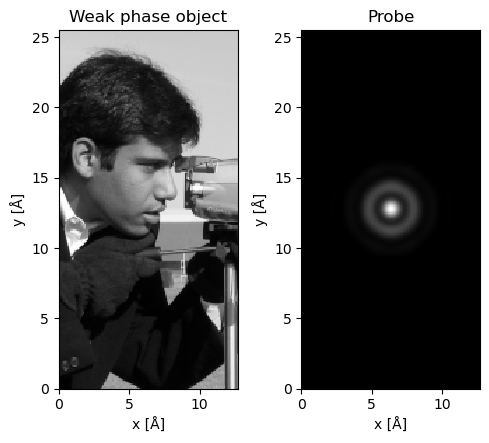

In [1]:
import numpy as np
from skimage import data
from abtem import GridScan, PixelatedDetector, PotentialArray, Probe
import matplotlib.pyplot as plt

image = data.camera().astype(np.float32)
image = image[50 : 50 + 2 * 128, 170 : 170 + 128].T[:, ::-1]
image = image / image.max() * 1e3
potential = PotentialArray(image[None], [0.0], sampling=0.1)

probe = Probe(semiangle_cutoff=20, energy=80e3, defocus=300, Cs=1e6)
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
potential.project().show(ax=ax1, title="Weak phase object")
probe.show(ax=ax2, title="Probe")

fig.tight_layout()

We simulate diffraction patterns covering the entire (periodic) test object:

In [2]:
gridscan_start = np.array([0, 0])
gridscan_end = potential.extent - gridscan_start
gridscan = GridScan(gridscan_start, gridscan_end, sampling=1, endpoint=False)
pixelated_detector = PixelatedDetector(max_angle=None)
pixelated_measurement = probe.scan(gridscan, pixelated_detector, potential)

Scan:   0%|          | 0/338 [00:00<?, ?it/s]

We use the `RegularizedPtychographicOperator` object from `abtem.reconstruct`, explained in previous tutorials.

In [3]:
from abtem.reconstruct import RegularizedPtychographicOperator

periodic_simulation_ptycho_operator = RegularizedPtychographicOperator(
    pixelated_measurement,
    energy=80e3,
    semiangle_cutoff=10,
    device="gpu",
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    objects_01,
    probes_01,
    positions_01,
    sse_01,
) = periodic_simulation_ptycho_operator.reconstruct(
    max_iterations=20, verbose=True, random_seed=1, return_iterations=True
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 6760 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.241e-06
----Iteration 1 , SSE = 9.789e-07
----Iteration 2 , SSE = 5.803e-07
----Iteration 3 , SSE = 2.043e-07
----Iteration 4 , SSE = 7.857e-08
----Iteration 5 , SSE = 3.989e-08
----Iteration 6 , SSE = 2.521e-08
----Iteration 7 , SSE = 1.792e-08
----Iteration 8 , SSE = 1.262e-08
----Iteration 9 , SSE = 9.635e-09
----Iteration 10, SSE = 7.498e-09
----Iteration 11, SSE = 5.561e-09
----Iteration 12, SSE = 4.155e-09
----Iteration 13, SSE = 3.097e-09
----Iteration 14, SSE = 2.276e-09
----Iteration 15, SSE = 1.736e-09
----Iteration 16, SSE = 1.420e-09
----Iteration 17, SSE = 1.211e-09
----Iteration 18, SSE = 9.710e-10
----Iteration 19, SSE = 7.988e-10


Let's investigate our reconstructed object and probe:

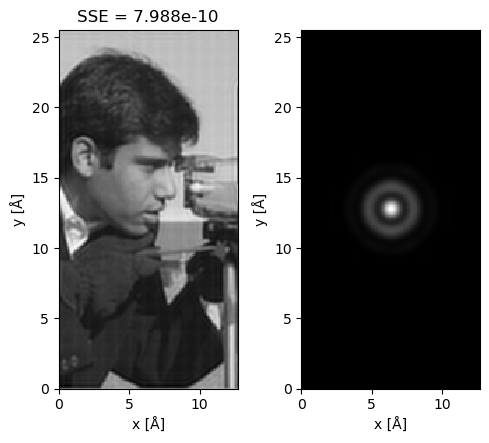

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
objects_01[-1].angle().show(ax=ax1, title=f"SSE = {float(sse_01[-1]):.3e}")
probes_01[-1].intensity().show(ax=ax2)
fig.tight_layout()

Indeed, the algorithm properly accounted for all probe aberrations, and achieved a fairly good reconstruction quality!  

_Note:_ The object we're trying to reconstruct is not in-fact periodic and while the redundancy in the dataset mostly corrected for this, we can see evidence of periodicity on the center-right of the image (shadow due to the darker 'hair' on the center-left side of the image)

## Padded Reconstruction  
The obvious solution is to pad our image and perform the scanning-probe simulations again

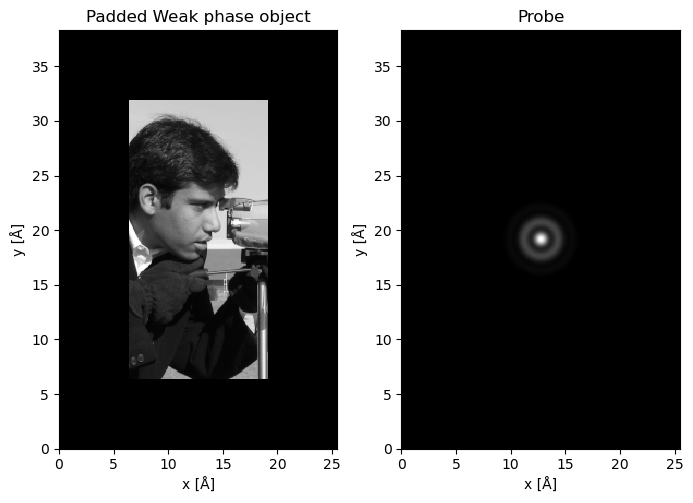

In [5]:
padded_image = np.pad(image, ((64, 64), (64, 64)))
padded_potential = PotentialArray(padded_image[None], [0.0], sampling=0.1)

padded_probe = Probe(semiangle_cutoff=20, energy=80e3, defocus=300, Cs=1e6)
padded_probe.grid.match(padded_potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
padded_potential.project().show(ax=ax1, title="Padded Weak phase object")
padded_probe.show(ax=ax2, title="Probe")

fig.tight_layout()

In [6]:
gridscan_start_padded = np.array(padded_potential.sampling) * (64, 64)
gridscan_end_padded = padded_potential.extent - gridscan_start_padded
gridscan_padded = GridScan(
    gridscan_start_padded, gridscan_end_padded, sampling=1, endpoint=True
)
pixelated_detector_padded = PixelatedDetector(max_angle=None)
pixelated_measurement_padded = padded_probe.scan(
    gridscan_padded, pixelated_detector_padded, padded_potential
)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

We can use a nearly-identical reconstruction setup, but here we again specify the non-zero padding

In [7]:
nonperiodic_simulation_ptycho_operator = RegularizedPtychographicOperator(
    pixelated_measurement_padded,
    energy=80e3,
    semiangle_cutoff=10,
    device="gpu",
    parameters={"object_px_padding": (64, 64)},
).preprocess()

(
    objects_02,
    probes_02,
    positions_02,
    sse_02,
) = nonperiodic_simulation_ptycho_operator.reconstruct(
    max_iterations=20, random_seed=1, return_iterations=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

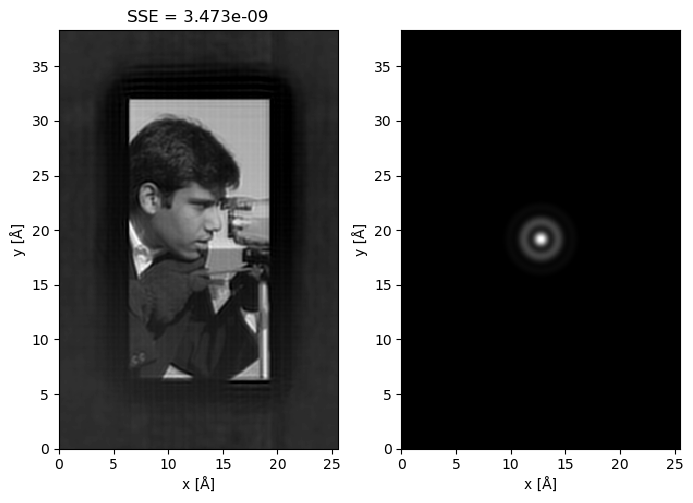

In [8]:
vmin = np.amin(np.angle(objects_02[-1].array[64:-64, 64:-64]))
vmax = np.amax(np.angle(objects_02[-1].array[64:-64, 64:-64]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
objects_02[-1].angle().show(
    ax=ax1, vmin=vmin, vmax=vmax, title=f"SSE = {float(sse_02[-1]):.3e}"
)
probes_02[-1].intensity().show(ax=ax2)
fig.tight_layout()

Indeed, we can produce a faithful reconstruction by eliminating these artifacts, as evidenced by the absence of the aforementioned 'shadow' in the center-right of the image

### Side-note:

In the above reconstructions, we initialized the objects array with `1.0j` and the probe array with a `Probe` object using the specified `energy` and `semiangle_cutoff`.  
We can also directly input `objects` and `probes` parameters to our reconstruction object during initialization. This is particularly useful for restarting calculations:

In [9]:
nonperiodic_simulation_ptycho_operator_02 = RegularizedPtychographicOperator(
    pixelated_measurement_padded,
    energy=80e3,
    objects=objects_02[-1].array,
    probes=probes_02[-1].array,
    device="gpu",
    parameters={"object_px_padding": (64, 64)},
).preprocess()

(
    objects_03,
    probes_03,
    positions_03,
    sse_03,
) = nonperiodic_simulation_ptycho_operator_02.reconstruct(
    max_iterations=1, random_seed=1, verbose=True, return_iterations=True
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 378 steps
--Probe correction is enabled


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0, SSE = 3.741e-09


## Fixed-Angular Sampling CBED Patterns

Notice that the simulations above used `max_angle=None` and `resample=False`. This results in ideal real-space resolution, but is unrealistic for experiments, where the detector pixel-spacing is determined by other factors such as the camera length. This also inherits the aspect ratio of the potential, resulting in non-uniform angular spacing for our CBED patterns.

To simulate a more realistic scenario, we downsample to a (larger) uniform angular spacing, e.g. here we use 1.5x the maximum angular sampling set by the object's extent 

In [10]:
pixelated_detector_padded_downsampled = PixelatedDetector(
    max_angle=None, resample=(np.max(padded_probe.angular_sampling) * 3 / 2,) * 2
)
pixelated_measurement_padded_downsampled = padded_probe.scan(
    gridscan_padded, pixelated_detector_padded_downsampled, padded_potential
)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

Let's visualize our two PACBED patterns, which should be identical subject to downsampling errors.

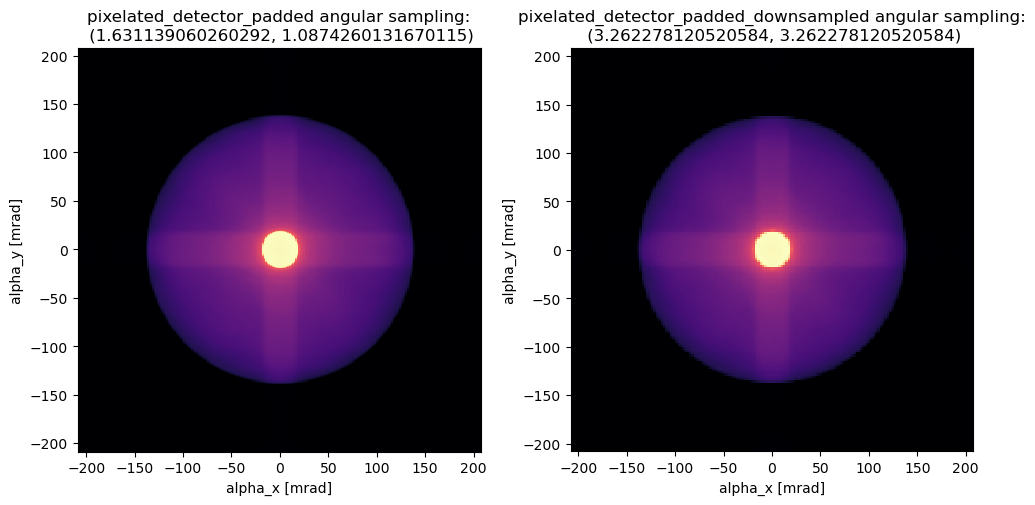

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

pixelated_measurement_padded.mean(axis=(0, 1)).show(
    power=0.125,
    ax=ax1,
    cmap="magma",
    title=f"pixelated_detector_padded angular sampling:\n {padded_probe.angular_sampling}",
)
pixelated_measurement_padded_downsampled.mean(axis=(0, 1)).show(
    power=0.125,
    ax=ax2,
    cmap="magma",
    title=f"pixelated_detector_padded_downsampled angular sampling:\n {(np.max(padded_probe.angular_sampling)*2,)*2}",
)
fig.tight_layout()

We can check that both CBED patterns give the same spatial resolution (given by `padded_potential.sampling`):

In [12]:
from abtem.utils import energy2wavelength

pixelated_measurement_padded_sampling = tuple(
    energy2wavelength(80e3) * 1000 / (cal.sampling * pixels)
    for cal, pixels in zip(
        pixelated_measurement_padded.calibrations[-2:],
        pixelated_measurement_padded.shape[-2:],
    )
)

pixelated_measurement_padded_downsampled_sampling = tuple(
    energy2wavelength(80e3) * 1000 / (cal.sampling * pixels)
    for cal, pixels in zip(
        pixelated_measurement_padded_downsampled.calibrations[-2:],
        pixelated_measurement_padded_downsampled.shape[-2:],
    )
)

print(
    f"""
    pixelated_measurement sampling: {pixelated_measurement_padded_sampling}
    pixelated_measurement_downsampled sampling: {pixelated_measurement_padded_downsampled_sampling}
    object sampling: {padded_potential.sampling}"""
)


    pixelated_measurement sampling: (0.10000000149011612, 0.10000000397364295)
    pixelated_measurement_downsampled sampling: (0.09980506971333228, 0.09980506971333228)
    object sampling: (0.1, 0.10000000000000002)


However, our downsampled CBED patterns cover only a small extent of the original object:

In [13]:
pixelated_measurement_padded_extent = tuple(
    sampling * pixels
    for sampling, pixels in zip(
        pixelated_measurement_padded_sampling, pixelated_measurement_padded.shape[-2:]
    )
)

pixelated_measurement_padded_downsampled_extent = tuple(
    sampling * pixels
    for sampling, pixels in zip(
        pixelated_measurement_padded_downsampled_sampling,
        pixelated_measurement_padded_downsampled.shape[-2:],
    )
)

print(
    f"""
    pixelated_measurement extent: {pixelated_measurement_padded_extent}
    pixelated_measurement_downsampled extent: {pixelated_measurement_padded_downsampled_extent}
    object extent: {padded_potential.extent}"""
)


    pixelated_measurement extent: (25.600000381469727, 38.40000152587889)
    pixelated_measurement_downsampled extent: (17.06666692097982, 17.06666692097982)
    object extent: (25.6, 38.400000000000006)


As such, we'll need to tile our object with a CBED-sized probe.  
More specifically, we'll call this moving window our region of interest (ROI) and call its dimensions `(R,S)`, which we'll require are at-least as large as our CBED pattern dimensions `(M,N)`.  

_Note:_ The probe ROI needs to be large enough to include most of the probe, with minimal boundary artifacts.

_Note:_ We will typically work with square CBED patterns, resulting in $(R,R)\ge (M,M)$, but we allow non-square dimensions to support the simulated full-extent CBED patterns.

Our object has dimensions $(P,Q) \ge (R,S)$ which cover the entire padded object.

E.g. we can use a square ROI probe guess using the same extent as our CBED patterns above:

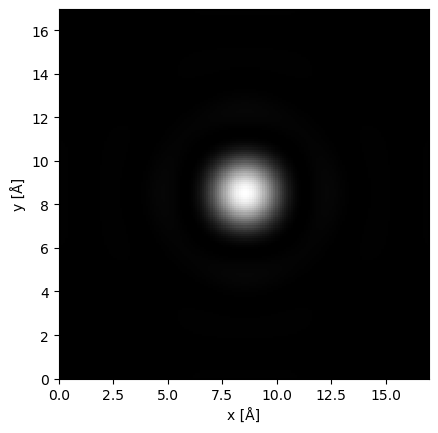

In [14]:
probe_roi = Probe(
    semiangle_cutoff=10,
    energy=80e3,
    sampling=pixelated_measurement_padded_downsampled_sampling,
    gpts=pixelated_measurement_padded_downsampled.shape[-2:],
)

probe_roi.show();

Most of our probe fits inside the ROI, so let's go ahead and reconstruct using these dimensions.  
_Note:_ If this wasn't the case, the object below also accepts a `region_of_interest_shape` parameter and zero-pads the CBED patterns accordingly

In [15]:
fixed_angular_sampling_ptycho_operator = RegularizedPtychographicOperator(
    pixelated_measurement_padded_downsampled,
    energy=80e3,
    semiangle_cutoff=10,
    device="gpu",
    parameters={"object_px_padding": (64, 64)},
).preprocess()

(
    objects_04,
    probes_04,
    positions_04,
    sse_04,
) = fixed_angular_sampling_ptycho_operator.reconstruct(
    max_iterations=20, random_seed=1, return_iterations=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

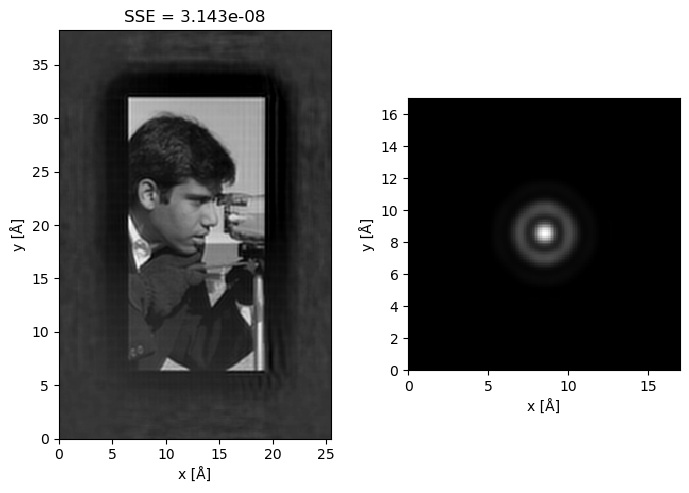

In [16]:
vmin = np.amin(np.angle(objects_04[-1].array[64:-64, 64:-64]))
vmax = np.amax(np.angle(objects_04[-1].array[64:-64, 64:-64]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
objects_04[-1].angle().show(
    ax=ax1, vmin=vmin, vmax=vmax, title=f"SSE = {float(sse_04[-1]):.3e}"
)
probes_04[-1].intensity().show(ax=ax2)
fig.tight_layout()

Our reconstruction error is (naturally) larger than in the ideal case before, but the results should be satisfactory for many purposes.

## Limited Scattering Angles

So far, we've used `max_angle=None`, however our experimental detector geometry may further be limited to a certain maximum angle:

In [17]:
pixelated_detector_padded_limited = PixelatedDetector(max_angle=103, resample="uniform")
pixelated_measurement_padded_limited = padded_probe.scan(
    gridscan_padded, pixelated_detector_padded_limited, padded_potential
)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

This will limit our spatial sampling:

pixelated_measurement_padded_limited sampling: (0.20000000298023224, 0.20000000298023224)


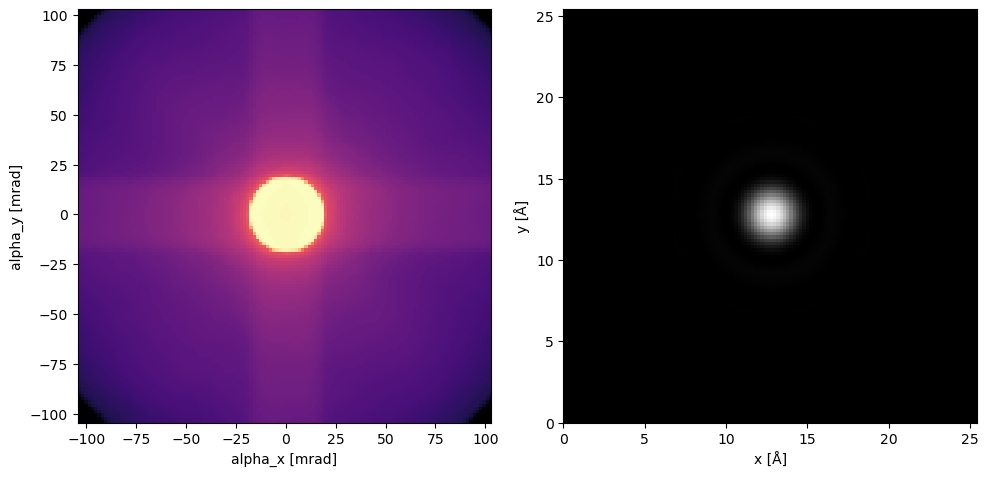

In [18]:
pixelated_measurement_padded_limited_sampling = tuple(
    energy2wavelength(80e3) * 1000 / (cal.sampling * pixels)
    for cal, pixels in zip(
        pixelated_measurement_padded_limited.calibrations[-2:],
        pixelated_measurement_padded_limited.shape[-2:],
    )
)

print(
    f"pixelated_measurement_padded_limited sampling: {pixelated_measurement_padded_limited_sampling}"
)

probe_roi_limited = Probe(
    semiangle_cutoff=10,
    energy=80e3,
    sampling=pixelated_measurement_padded_limited_sampling,
    gpts=pixelated_measurement_padded_limited.shape[-2:],
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pixelated_measurement_padded_limited.mean(axis=(0, 1)).show(
    power=0.125, cmap="magma", ax=ax1
)
probe_roi_limited.show(ax=ax2)
fig.tight_layout()

In [19]:
limited_scattering_angles_ptycho_operator = RegularizedPtychographicOperator(
    pixelated_measurement_padded_limited,
    energy=80e3,
    semiangle_cutoff=10,
    device="gpu",
    parameters={"object_px_padding": (32, 32)},
).preprocess()

(
    objects_05,
    probes_05,
    positions_05,
    sse_05,
) = limited_scattering_angles_ptycho_operator.reconstruct(
    max_iterations=20, random_seed=1, return_iterations=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

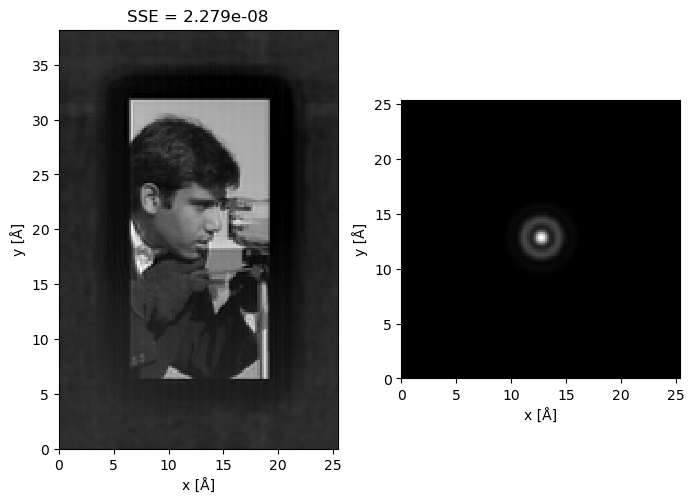

In [20]:
vmin = np.amin(np.angle(objects_05[-1].array[32:-32, 32:-32]))
vmax = np.amax(np.angle(objects_05[-1].array[32:-32, 32:-32]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
objects_05[-1].angle().show(
    ax=ax1, vmin=vmin, vmax=vmax, title=f"SSE = {float(sse_05[-1]):.3e}"
)
probes_05[-1].intensity().show(ax=ax2)
fig.tight_layout()

Even though our object array is twice as small, since all our scattering information was maintained in the CBED region we cropped to and due to the sub-pixel corrective power of the algorithm, we achieve near identical reconstruction quality!

## Position Correction

We also investigate the common experimental case where the probe positions are not known precisely (e.g. due to drift during acquisition).  
In order to simulate the uncertainty in the probe positions, we create a custom-positions scan by adding small random perturbations to our gridscan positions.

In [21]:
from abtem.measure import Measurement
from abtem.scan import PositionScan

positions_random = gridscan_padded.get_positions()
positions_random += (np.random.random(positions_random.shape) * 2 - 1) / 5
randomscan_padded = PositionScan(positions_random)

pixelated_measurement_random = padded_probe.scan(
    randomscan_padded, pixelated_detector_padded_downsampled, padded_potential
)
pixelated_measurement_random = Measurement(
    pixelated_measurement_random.array.reshape(
        pixelated_measurement_padded_downsampled.shape
    ),
    pixelated_measurement_padded_downsampled.calibrations,
)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

We first see how well the reconstruction algorithm performs on its own (assuming a fixed grid of positions)

In [22]:
position_correction_ptycho_operator = RegularizedPtychographicOperator(
    pixelated_measurement_random,
    energy=80e3,
    semiangle_cutoff=10,
    device="gpu",
    parameters={"object_px_padding": (64, 64)},
).preprocess()

(
    objects_06,
    probes_06,
    positions_06,
    sse_06,
) = position_correction_ptycho_operator.reconstruct(
    max_iterations=20,
    random_seed=1,
    return_iterations=True,
    parameters={"step_size_damping_rate": 0.75},
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

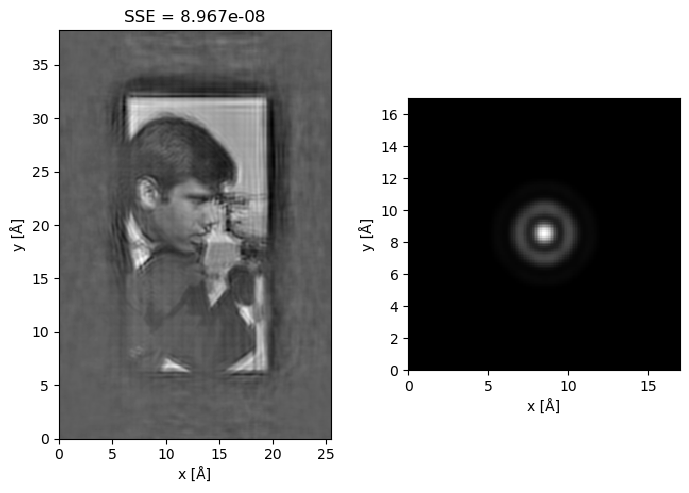

In [23]:
vmin = np.amin(np.angle(objects_06[-1].array[64:-64, 64:-64]))
vmax = np.amax(np.angle(objects_06[-1].array[64:-64, 64:-64]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
objects_06[-1].angle().show(
    ax=ax1, vmin=vmin, vmax=vmax, title=f"SSE = {float(sse_06[-1]):.3e}"
)
probes_06[-1].intensity().show(ax=ax2)
fig.tight_layout()

Our error is substantially larger than before.  
Let's see if position correction can help:

In [24]:
position_correction_ptycho_operator_02 = RegularizedPtychographicOperator(
    pixelated_measurement_random,
    energy=80e3,
    semiangle_cutoff=10,
    device="gpu",
    parameters={"object_px_padding": (64, 64)},
).preprocess()

(
    objects_07,
    probes_07,
    positions_07,
    sse_07,
) = position_correction_ptycho_operator_02.reconstruct(
    max_iterations=20,
    random_seed=1,
    return_iterations=True,
    parameters={
        "pre_position_correction_update_steps": position_correction_ptycho_operator._num_diffraction_patterns
        * 5,
        "position_step_size": 0.5,
        "step_size_damping_rate": 0.75,
    },
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

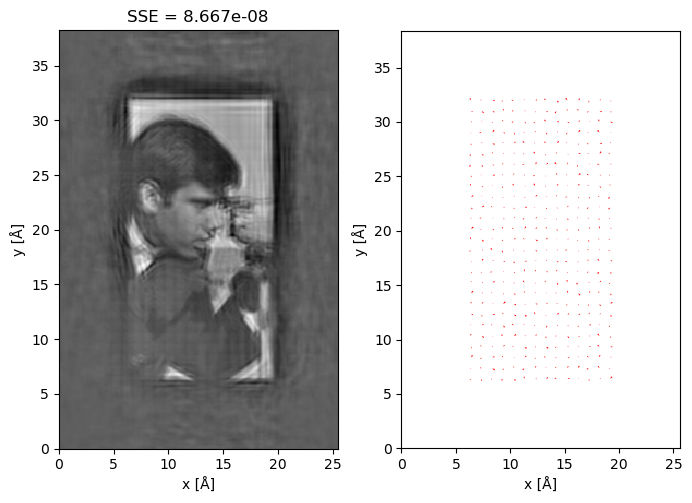

In [25]:
vmin = np.amin(np.angle(objects_07[-1].array[64:-64, 64:-64]))
vmax = np.amax(np.angle(objects_07[-1].array[64:-64, 64:-64]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
objects_07[-1].angle().show(
    ax=ax1, vmin=vmin, vmax=vmax, title=f"SSE = {float(sse_07[-1]):.3e}"
)

ax2.quiver(
    *zip(*np.hstack((positions_random, positions_07[-1] - positions_random))),
    facecolors="r",
    scale=1,
    scale_units="xy",
)
ax2.set_aspect("equal")
ax2.set(
    xlabel="x [Å]",
    ylabel="y [Å]",
    xlim=(0, padded_potential.extent[0]),
    ylim=(0, padded_potential.extent[1]),
)
fig.tight_layout()

This is admiteddly not an impressive improvement in error, but the arrow plot on the right suggests the random positions have been recovered reasonably well.